## Classificazione con Decision Tree

In questa sezione si applica un **albero di decisione supervisionato** (DecisionTreeClassifier) per classificare i Pokémon in uno dei **quattro archetipi** individuati precedentemente tramite clustering:
- **Tank**
- **Bilanciati**
- **Offensivi**
- **Elite / Leggendari**

L’obiettivo è capire **quanto bene un modello interpretabile come l’albero** riesca a distinguere i Pokémon nei 4 archetipi, **utilizzando solo le quattro feature numeriche principali**:
- `OFF_FISICO`
- `OFF_SPECIALE`
- `TANK_FISICO`
- `TANK_SPECIALE`

tutte le altre feature come speed, hp etc. sono risultate in precedenti test non documentati poco
valide a fini dello splitting)
Il modello sarà validato mediante una **Stratified 10-Fold Cross Validation**, in modo da ottenere **medie e deviazioni standard** per ciascuna metrica (Accuracy, Precision, Recall, F1-score).

L’**iperparametro analizzato sarà `max_depth`**, che controlla la profondità massima dell’albero: un parametro cruciale per regolare il **bias/varianza trade-off** e prevenire l’overfitting. Una maggiore
profondità dell'albero si trasforma in una maggior complessità del modello e quindi overfitting.
La metrica di riferimento sarà la **F1 macro**, adatta anche in presenza di classi sbilanciate.

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    ConfusionMatrixDisplay
)
import numpy as np

Caricamento del traning set e setup dell'ambiente
In questa sezione selezioniamo le 4 caratteristiche numeriche (offensive e difensive, fisiche e speciali) come input del modello.
Il target è la classe `Archetipo`, ovvero una delle 4 etichette: "Tank", "Bilanciati", "Attaccanti", "Elite/Leggendari".


In [9]:
TRAINING_PATH = "risorse/training_bilanciato.csv"
TEST_PATH     = "risorse/test_set.csv"
FEATURES = ["OFF_FISICO", "OFF_SPECIALE", "TANK_FISICO", "TANK_SPECIALE"]
TARGET   = "Archetipo"

df_train = pd.read_csv(TRAINING_PATH)
df_test  = pd.read_csv(TEST_PATH)

# Controllo colonne
missing_train = [c for c in FEATURES + [TARGET] if c not in df_train.columns]
missing_test  = [c for c in FEATURES + [TARGET] if c not in df_test.columns]
if missing_train:
    raise KeyError(f"Mancano colonne nel TRAINING SET: {missing_train}")
if missing_test:
    raise KeyError(f"Mancano colonne nel TEST SET: {missing_test}")

# Selezione e copia
df_train = df_train[FEATURES + [TARGET]].copy()
df_test  = df_test[FEATURES + [TARGET]].copy()

# Conversione a numerico
for c in FEATURES:
    df_train[c] = pd.to_numeric(df_train[c], errors="coerce")
    df_test[c]  = pd.to_numeric(df_test[c],  errors="coerce")

# Drop NaN (train e test)
before = len(df_train)
df_train = df_train.dropna(subset=FEATURES + [TARGET])
after = len(df_train)
if after < before:
    print(f"Attenzione: rimosse {before - after} righe (NaN) dal TRAINING.")

before_t = len(df_test)
df_test  = df_test.dropna(subset=FEATURES + [TARGET])
after_t  = len(df_test)
if after_t < before_t:
    print(f"Attenzione: rimosse {before_t - after_t} righe (NaN) dal TEST.")

# Distribuzioni classi
print("Distribuzione classi del TRAINING SET (y_train):")
x_train = df_train[FEATURES].values
y_train = df_train[TARGET].values
print(pd.Series(y_train).value_counts(normalize=True).round(2))
print(pd.Series(y_train).value_counts())

print("\nDistribuzione classi del TEST SET (y_test):")
x_test = df_test[FEATURES].values
y_test = df_test[TARGET].values
print(pd.Series(y_test).value_counts(normalize=True).round(2))
print(pd.Series(y_test).value_counts())

Distribuzione classi del TRAINING SET (y_train):
Balanced             0.25
Attaccante           0.25
Tank                 0.25
Elite/Leggendario    0.25
Name: proportion, dtype: float64
Balanced             245
Attaccante           245
Tank                 245
Elite/Leggendario    245
Name: count, dtype: int64

Distribuzione classi del TEST SET (y_test):
Attaccante           0.36
Balanced             0.31
Tank                 0.22
Elite/Leggendario    0.11
Name: proportion, dtype: float64
Attaccante           54
Balanced             47
Tank                 33
Elite/Leggendario    17
Name: count, dtype: int64


### 10-Fold Cross Validation per selezione dell'iperparametro `k`

In questa fase, stiamo valutando le prestazioni del classificatore su un range di valori dell'iperparametro `k`. In questo caso K = max_depth (massima profondità)
Per ciascun valore di `k`, applichiamo una **10-fold cross validation**: il dataset di training viene suddiviso in 10 partizioni stratificate, e per ogni fold si utilizza una partizione come validation set e le restanti 9 per il training.

Ogni esecuzione (fold) produce una serie di metriche (Accuracy, Precision, Recall, F1-score), che vengono **mediante su 10 run** per ottenere una stima affidabile delle performance per quel valore di `k`.

Inoltre, per ciascuna metrica, calcoliamo anche la **deviazione standard**, che ci fornisce un'indicazione della **stabilità del modello** rispetto a diverse partizioni del dataset.

> L'obiettivo di questo processo è:
> - valutare le prestazioni attese "in media" su dati non visti,
> - identificare il valore ottimale di `k` che massimizza, ad esempio, la F1 macro,
> - evitare scelte arbitrarie o basate su singole run (come richiesto nelle linee guida del corso).

Questa strategia è preferita rispetto a una singola divisione train/test perché garantisce maggiore robustezza statistica e riduce la varianza associata alla scelta casuale del validation set.

"Per ogni iperparametro testato, abbiamo calcolato la deviazione standard per stimare la stabilità delle metriche di valutazione al variare del validation set, come richiesto per garantire la robustezza statistica dei risultati."

In [10]:
# Valori da testare per la profondità dell'albero
depth_grid = list(range(1, 21))  # da 1 a 20

# Definizione del K-Fold stratificato
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Metriche da calcolare in cross-validation
scoring = {
    "accuracy": "accuracy",
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

# Lista dei risultati
cv_results = []

# Ciclo su ciascun valore di profondità
for d in depth_grid:
    #Istanza del classificatore Decision Tree
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_validate(clf, x_train, y_train, cv=cv, scoring=scoring)

    cv_results.append({
        "depth": d,
        "acc_mean":  scores["test_accuracy"].mean(),
        "acc_std":   scores["test_accuracy"].std(),

        "prec_mean": scores["test_precision_macro"].mean(),
        "prec_std":  scores["test_precision_macro"].std(),

        "rec_mean":  scores["test_recall_macro"].mean(),
        "rec_std":   scores["test_recall_macro"].std(),

        "f1_mean":   scores["test_f1_macro"].mean(),
        "f1_std":    scores["test_f1_macro"].std(),
    })

# Creazione del DataFrame con tutti i risultati
cv_table = pd.DataFrame(cv_results)

# Ordinamento per profondità crescente
cv_table = cv_table.sort_values("depth").reset_index(drop=True)

# Visualizzazione
pd.set_option("display.precision", 4)  # più leggibile
# Media globale delle metriche su tutti i k testati
global_stats = {
    "Accuracy": f"{cv_table['acc_mean'].mean():.3f} ± {cv_table['acc_std'].mean():.3f}",
    "Precisione": f"{cv_table['prec_mean'].mean():.3f} ± {cv_table['prec_std'].mean():.3f}",
    "Richiamo": f"{cv_table['rec_mean'].mean():.3f} ± {cv_table['rec_std'].mean():.3f}",
    "F1-score": f"{cv_table['f1_mean'].mean():.3f} ± {cv_table['f1_std'].mean():.3f}",
}

# Tabella con valori "metric ± std"
display(cv_table)
df_global_stat = pd.DataFrame(global_stats, index=["Media ± std su tutti i k"])
display(df_global_stat)


,depth,acc_mean,acc_std,prec_mean,prec_std,rec_mean,rec_std,f1_mean,f1_std
0,1,0.4531,0.0122,0.2750,0.0141,0.4540,0.0141,0.3240,0.0084
1,2,0.6959,0.0305,0.7401,0.0488,0.6960,0.0314,0.6547,0.0345
2,3,0.8449,0.0261,0.8555,0.0307,0.8445,0.0263,0.8456,0.0272
3,4,0.8949,0.0335,0.8988,0.0340,0.8948,0.0336,0.8938,0.0342
4,5,0.9031,0.0271,0.9059,0.0271,0.9032,0.0275,0.9021,0.0271
5,6,0.9327,0.0300,0.9347,0.0297,0.9328,0.0300,0.9326,0.0301
6,7,0.9327,0.0224,0.9354,0.0216,0.9328,0.0224,0.9324,0.0223
7,8,0.9378,0.0260,0.9403,0.0248,0.9377,0.0260,0.9375,0.0258
8,9,0.9357,0.0233,0.9380,0.0222,0.9357,0.0232,0.9355,0.0230
9,10,0.9378,0.0252,0.9400,0.0243,0.9378,0.0251,0.9377,0.0250


,Accuracy,Precisione,Richiamo,F1-score
Media ± std su tutti i k,0.893 ± 0.026,0.889 ± 0.026,0.893 ± 0.026,0.885 ± 0.026


### Grafico: F1-score (media ± deviazione standard) in funzione di max_depth
Visualizziamo la variazione dell’F1 macro rispetto alla profondità dell’albero. Le barre verticali rappresentano l’incertezza della stima (± std).
Questa visualizzazione aiuta a scegliere un valore di `max_depth` che bilanci performance e stabilità, evitando l’overfitting.


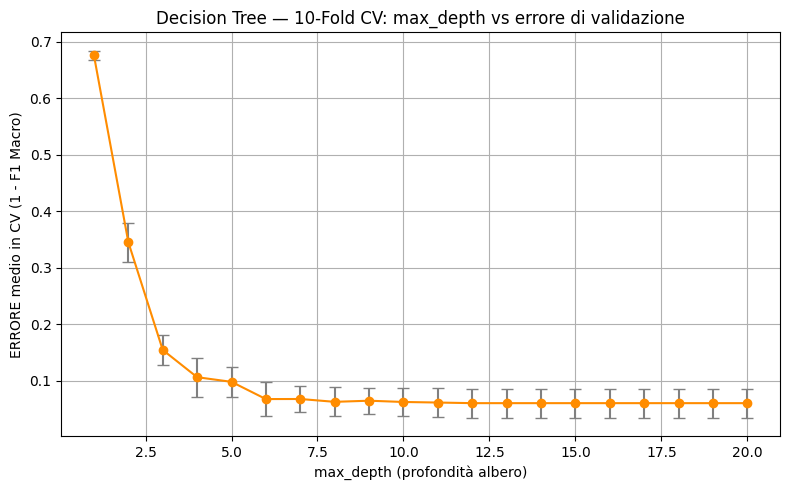

In [11]:
# === Analisi finale: errore medio e selezione best_depth ===
depth_values = cv_table["depth"]
mean_f1_errors = 1 - cv_table["f1_mean"]
std_f1_errors  = cv_table["f1_std"]

plt.figure(figsize=(8, 5))
plt.errorbar(
    depth_values,
    mean_f1_errors,
    yerr=std_f1_errors,
    fmt='-o',
    ecolor='gray',
    capsize=4,
    color='darkorange'
)

plt.xlabel("max_depth (profondità albero)")
plt.ylabel("ERRORE medio in CV (1 - F1 Macro)")
plt.title("Decision Tree — 10-Fold CV: max_depth vs errore di validazione")
plt.grid(True)
plt.tight_layout()
plt.show()

### Selezione della profondità dell’albero (`max_depth`)
Il valore `BEST_DEPTH` definisce la profondità massima usata per il training finale del modello.
Modificando questo valore puoi testare direttamente l’impatto della profondità sulla generalizzazione.

In [12]:
# Valore modificabile impostato da noi
BEST_DEPTH = 9

### Fit finale del Decision Tree sul training

In questo blocco:
- Addestriamo il modello Decision Tree sul training set bilanciato con iper-parametro scelto
- Valutiamo il modello appreso sul test set che prima di ora non è mai stato osservato dal modello\
- Valutiamo il modello sul test set attraverso 4 metriche:
  - **Accuracy**
  - **Precisione macro**
  - **Richiamo macro**
  - **F1-score macro**
- Visualizziamo infine la **matrice di confusione** per analizzare gli errori commessi dal modello sul test set


Accuracy:     0.874
Precisione:   0.855
Richiamo:     0.848
F1-score:     0.851


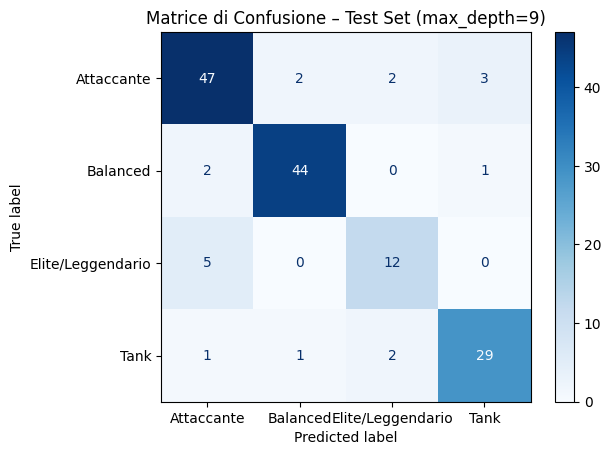

In [13]:
# Fit su training con profondità specificata
# criterio di split: Entropia
tree_clf = DecisionTreeClassifier(max_depth=BEST_DEPTH,
                                  criterion="entropy", random_state=42)
tree_clf.fit(x_train, y_train)

# Previsioni sul test set
y_pred = tree_clf.predict(x_test)

# Calcolo metriche (la f1 risulta essere quella per noi più interessante)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

print(f"Accuracy:     {acc:.3f}")
print(f"Precisione:   {prec:.3f}")
print(f"Richiamo:     {rec:.3f}")
print(f"F1-score:     {f1:.3f}")

# Matrice di confusione
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    cmap="Blues",
    normalize=None
)
plt.title(f"Matrice di Confusione – Test Set (max_depth={BEST_DEPTH})")
plt.grid(False)
plt.show()

Effetto dello sbilanciamento sul test set

Quando il training set è bilanciato e il test set no, succede questo:

| **Componente**       | **Effetto**                                                                 |
|----------------------|-----------------------------------------------------------------------------|
| **Training bilanciato** | Aiuta i modelli a non favorire le classi più frequenti → buona capacità di generalizzazione. |
| **Test sbilanciato**    | Le metriche semplici (es. accuracy) possono diventare ingannevoli, perché sono influenzate dalla classe predominante. |

È importante osservare che, mentre il training set è bilanciato, il test set presenta una distribuzione delle classi non uniforme, più simile a quella che si riscontra nei Pokémon reali. Questo squilibrio può penalizzare i modelli che non sono in grado di adattarsi bene a questa asimmetria. Tuttavia, la regressione logistica basata sulle distanze dai centroidi ha mostrato ottima robustezza anche in presenza di test sbilanciato, a differenza del Decision Tree, più influenzato dai confini rigidi tra le classi.

Le metriche ottenute sul test set per il classificatore DecisionTreeClassifier risultano pienamente coerenti con le medie osservate in fase di cross-validation.
In particolare, tutte le metriche del test set rientrano all'interno degli intervalli ± deviazione standard calcolati sulle 10-fold CV ripetute per diversi valori dell'iperparametro max_depth.
Questo risultato suggerisce che:
- il modello generalizza correttamente su dati non visti,
- la procedura di validazione adottata è affidabile,
- le metriche sono stabili anche in presenza di un test set potenzialmente sbilanciato.

## Decision Tree e soglie numeriche

L’analisi della matrice di confusione mostra che il **Decision Tree** è in grado di esprimere delle **soglie numeriche utili** per distinguere alcune classi di Pokémon:

- **Attaccante** e **Balanced** vengono classificati quasi perfettamente, segno che l’albero ha trovato regole chiare basate sui valori di *OFF_FISICO* e *OFF_SPECIALE*.
- Anche la classe **Tank** viene riconosciuta in modo soddisfacente, grazie a soglie legate a *TANK_FISICO* e *TANK_SPECIALE*.
- La maggiore difficoltà si riscontra nella classe **Elite/Leggendario**, che presenta valori alti su più dimensioni e tende a sovrapporsi con altre categorie, in particolare con *Attaccante*.

Questo conferma che, pur essendo **difficile classificare i Pokémon esclusivamente tramite soglie numeriche rigide**, il Decision Tree riesce comunque a costruire regole efficaci per molte classi, ottenendo metriche complessive elevate (F1-macro ≈ 0.85).
Le limitazioni emergono soprattutto nelle classi ibride o sovrapposte, dove algoritmi basati su distanza, come KNN, possono risultare più adatti a catturare la struttura a cluster dei dati.


Plottaggio dell'albero generato e classi più importanti

=== Importanza delle feature (Decision Tree) ===


,Feature,Importanza
0,OFF_FISICO,0.3541
1,TANK_FISICO,0.2414
2,OFF_SPECIALE,0.2045
3,TANK_SPECIALE,0.1999


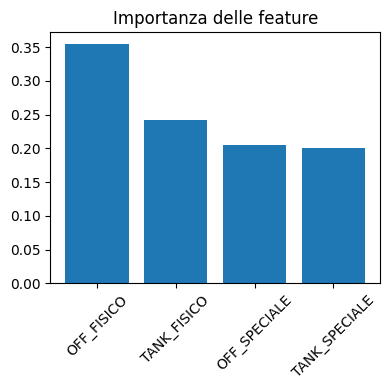

In [19]:
# === [Importanza delle feature - Decision Tree] ===

# Calcolo delle importanze e ordinamento decrescente
feature_importances = tree_clf.feature_importances_
feature_names = np.array(FEATURES)
sorted_idx = np.argsort(feature_importances)[::-1]

# Tabella con feature ordinate per importanza
df_importanza = pd.DataFrame({
    "Feature": feature_names[sorted_idx],
    "Importanza": feature_importances[sorted_idx]
})
df_importanza["Importanza"] = df_importanza["Importanza"].round(6)

# Visualizzazione tabellare
print("=== Importanza delle feature (Decision Tree) ===")
display(df_importanza)

# Visualizzazione grafica
plt.figure(figsize=(4, 4))
plt.title("Importanza delle feature")
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
plt.xticks(range(len(feature_importances)), feature_names[sorted_idx], rotation=45)
plt.tight_layout()
plt.show()

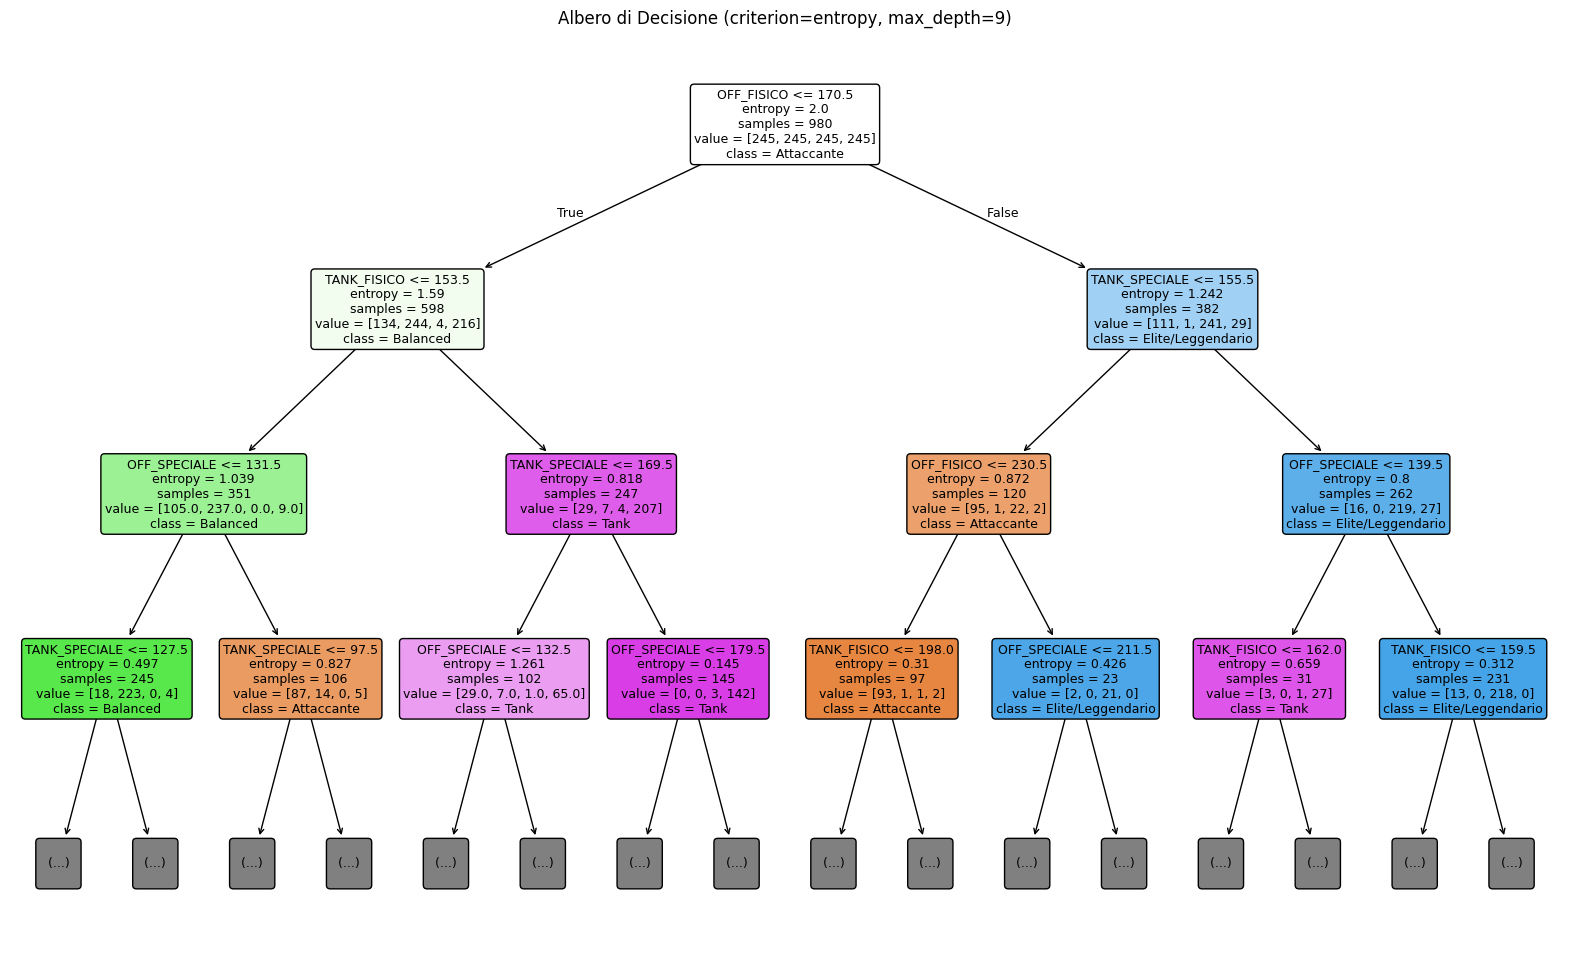

In [17]:
from sklearn.tree import plot_tree

# Plottaggio dell'albero
plt.figure(figsize=(20, 12))
plot_tree(
    tree_clf,
    feature_names=FEATURES,
    class_names=sorted(pd.Series(y_train).unique()),
    filled=True,
    rounded=True,
    impurity=True,
    proportion=False,
    max_depth=3,
    fontsize=9
)
plt.title(f"Albero di Decisione (criterion=entropy, max_depth={tree_clf.get_params()['max_depth']})")
plt.show()

# 3) Salva su file (per la tesi)
plt.figure(figsize=(28, 16))
plot_tree(tree_clf, feature_names=FEATURES, class_names=sorted(pd.Series(y_train).unique()),
          filled=True, rounded=True, impurity=True, proportion=False, fontsize=10)
plt.title("Decision Tree")
#plt.savefig("risorse/decision_tree.png", dpi=300, bbox_inches="tight")
plt.close()
#print("Salvato: risorse/decision_tree_colori.png")

Determiniamo le feature più importanti nello split.

L’albero di decisione ha assegnato maggiore importanza alla feature TANK_SPECIALE, segnalando che la componente difensiva speciale gioca un ruolo cruciale nella separazione tra gli archetipi.
Seguono le due componenti offensive (OFF_FISICO, OFF_SPECIALE) e infine la difesa fisica (TANK_FISICO).
Ciò suggerisce che i Pokémon con una forte difesa speciale vengono identificati come classe distinta più rapidamente.